In [2]:
from pathlib import Path
import os

data_path = Path("/home/mfclabber/fsoco_bounding_boxes_train")

def walk_through_dir(dir_path):
    """Walks through dir_path returning file counts of its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

walk_through_dir(data_path)

There are 41 directories and 1 files in '/home/mfclabber/fsoco_bounding_boxes_train'.
There are 2 directories and 0 files in '/home/mfclabber/fsoco_bounding_boxes_train/eufs'.
There are 0 directories and 125 files in '/home/mfclabber/fsoco_bounding_boxes_train/eufs/img'.
There are 0 directories and 125 files in '/home/mfclabber/fsoco_bounding_boxes_train/eufs/ann'.
There are 2 directories and 0 files in '/home/mfclabber/fsoco_bounding_boxes_train/ulm'.
There are 0 directories and 558 files in '/home/mfclabber/fsoco_bounding_boxes_train/ulm/img'.
There are 0 directories and 558 files in '/home/mfclabber/fsoco_bounding_boxes_train/ulm/ann'.
There are 2 directories and 0 files in '/home/mfclabber/fsoco_bounding_boxes_train/racetech'.
There are 0 directories and 244 files in '/home/mfclabber/fsoco_bounding_boxes_train/racetech/img'.
There are 0 directories and 244 files in '/home/mfclabber/fsoco_bounding_boxes_train/racetech/ann'.
There are 2 directories and 0 files in '/home/mfclabber/fso

Random image path: /home/mfclabber/fsoco_bounding_boxes_train/penn/img/amz_03873.png
Image height: 920
Image width: 2872


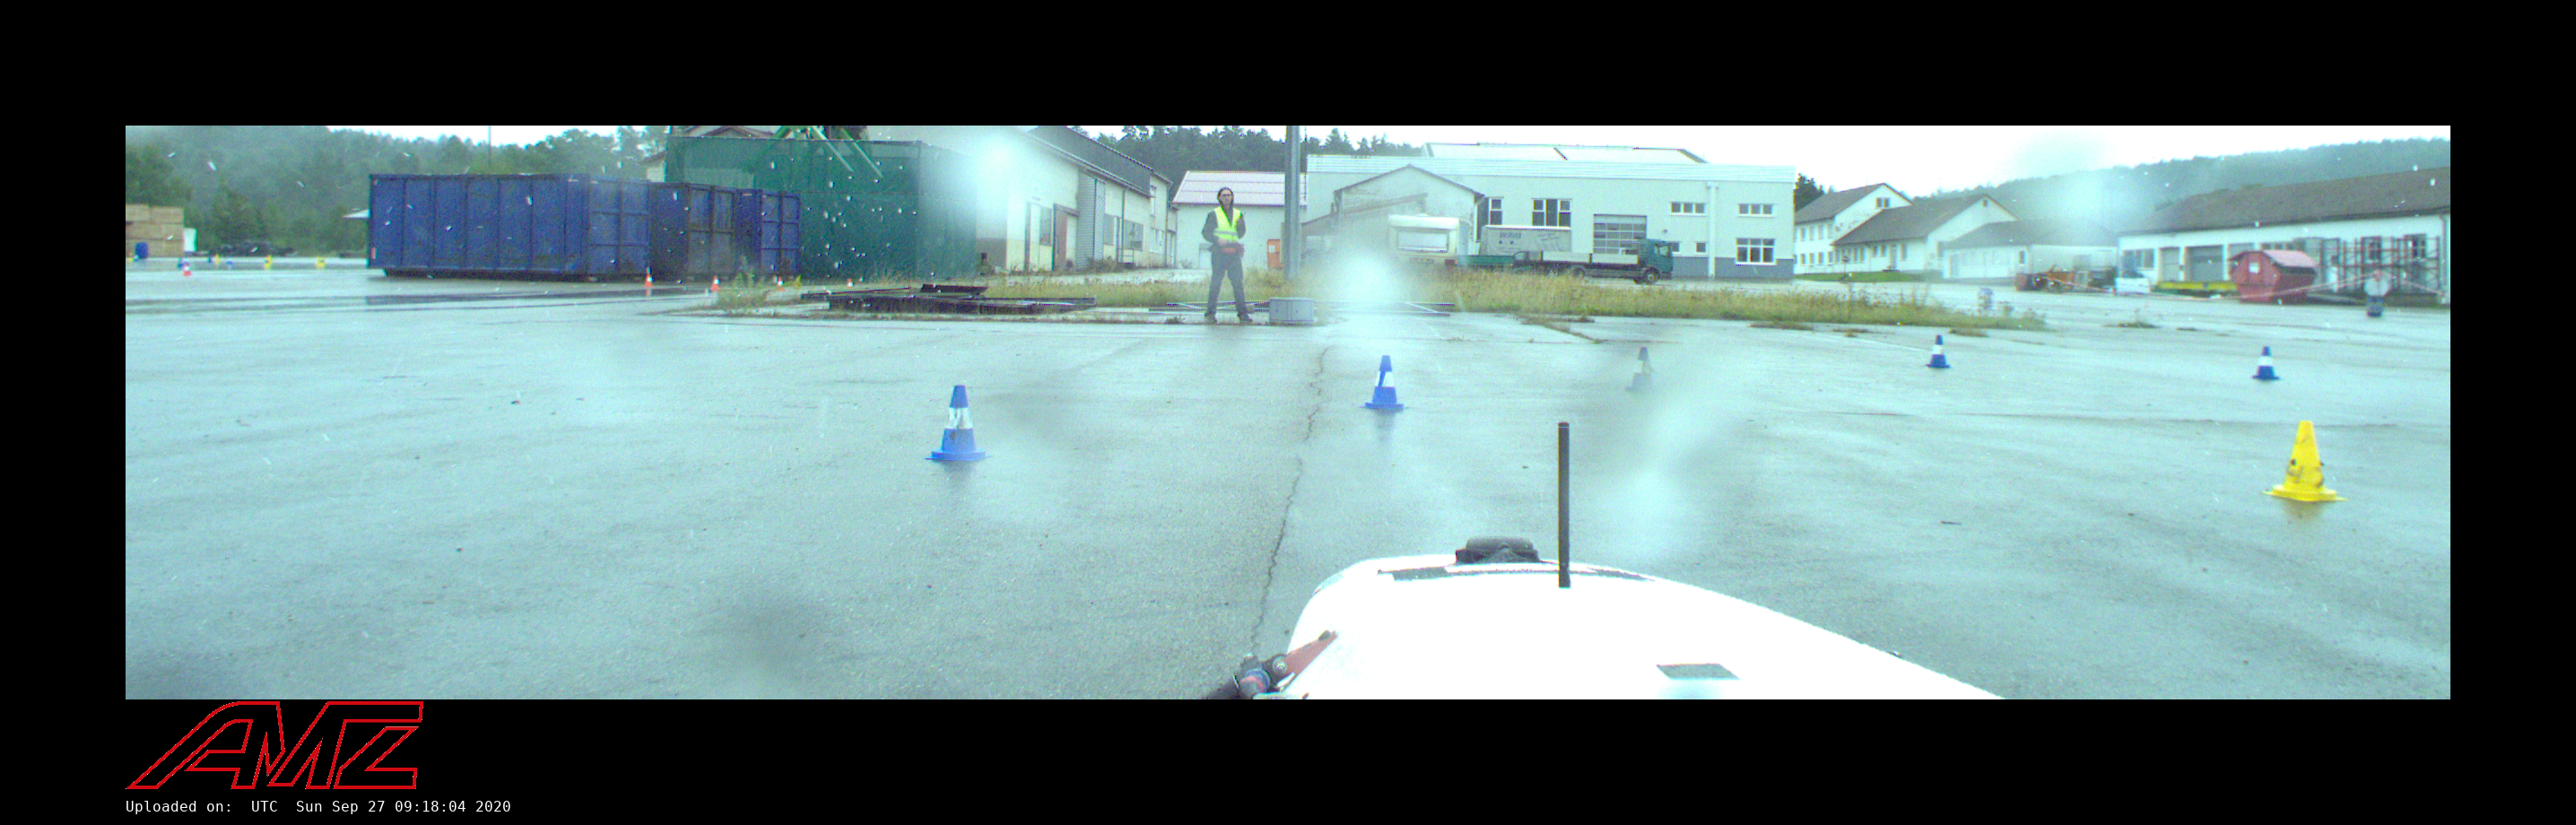

In [3]:
import random
from PIL import Image

image_path_list = sorted(list(data_path.glob("*/img/*.png")) +
                         list(data_path.glob("*/img/*.jpg")))

labels_path_list = sorted(list(data_path.glob("*/ann/*.json")))

random_image_path = random.choice(image_path_list)
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

In [25]:
import numpy as np
import torch
from PIL import ImageDraw

COLORS = dict([
    ("yellow_cone", (255, 255, 0)),
    ("blue_cone", (0, 0, 255)),
    ("large_orange_cone", (255, 122, 0)),
    ("orange_cone", (255, 122, 0)),
    ("unknown_cone", (255, 255, 255))
])

ID2LABEL = dict([
    (1, "yellow_cone"),
    (2, "blue_cone"),
    (3, "large_orange_cone"),
    (4, "orange_cone"),
    (0, "unknown_cone")
])

def objects_threshold_scores(bboxes: torch.Tensor, 
                         labels: torch.Tensor=None, 
                         scores: torch.Tensor=None,
                         threshold_score: float=0.1):
    bboxes_copy = copy.deepcopy(bboxes)
    labels_copy = copy.deepcopy(labels)
    scores_copy = copy.deepcopy(scores)

    bboxes = torch.Tensor([])
    labels, scores = list(), list()
    for i, score in enumerate(scores_copy):
        if score >= threshold_score:
            bboxes = torch.cat((bboxes, bboxes_copy[i].unsqueeze(dim=0)), dim=0)
            labels.append(labels_copy[i])
            scores.append(score)
    
#     bboxes = torch.Tensor(bboxes).unsqueeze(dim=0)
    labels = torch.Tensor(labels)
    scores = torch.Tensor(scores)

    del bboxes_copy, labels_copy, scores_copy

    return bboxes, labels, scores

def show_image_with_objects(image: np.array, 
                            bboxes_: torch.Tensor, 
                            labels: torch.Tensor=None, 
                            scores: torch.Tensor=None,
                            threshold_score: float=0.5):
    
    if image.shape[2] > 3:
        image = image.transpose(1, 2, 0)

    image = Image.fromarray(image)

    if scores != None:
        bboxes, labels, scores = objects_threshold_scores(bboxes, labels, scores, threshold_score)
        
    for i in range(len(bboxes_)):
        bboxes = bboxes_[i].flatten()
        draw = ImageDraw.Draw(image)
    
        if type(labels[i]) == str:
            draw.rectangle(bboxes.numpy(), outline = COLORS[labels[i]], width=2)
        else:
            draw.rectangle(bboxes.numpy(), outline = COLORS[ID2LABEL[int(labels[i])]], width=2)
#         if scores != None:
#             bbox = draw.textbbox((bboxes[0], bboxes[1]), f"ID{int(labels[i])} {scores[i] * 100:.2f}%")
#             draw.rectangle((bbox[0]-2, bbox[1]-2, bbox[2]+2, bbox[3]+2), fill=(0, 0, 0))
#             draw.text((bboxes[0], bboxes[1]), f"ID{int(labels[i])} {scores[i] * 100:.2f}%", color[0])
#         else:
#             bbox = draw.textbbox((bboxes[0], bboxes[1]), f"ID {labels[i]}")
#             draw.rectangle((bbox[0]-2, bbox[1]-2, bbox[2]+2, bbox[3]+2), fill=(0, 0, 0))
#             draw.text((bboxes[0], bboxes[1]), f"ID {labels[i]}", color[labels[i].split('_')[0]])
    return image

# image = Image.open(image_path_list[0])
# show_image_with_objects(np.array(image.convert('RGB')), torch.Tensor(bboxes), labels)

In [5]:
import os
import cv2
import random
import pathlib
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from sklearn.model_selection import train_test_split

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import PIL
from PIL import Image, ImageFile, ImageFont, ImageDraw, ImageEnhance
ImageFile.LOAD_TRUNCATED_IMAGES = True

import copy
import json
import random
from time import time

import warnings
warnings.filterwarnings('ignore')

FUSED_SHAPE = (1280, 640)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/mfclabber/anaconda3/envs/ml_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mfclabber/anaconda3/envs/ml_env/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
class FS_COCO_Dataset(Dataset):
    def __init__(self, 
                 images_pathes_list: pathlib.Path, 
                 annotations: pathlib.Path,
                 transform: torchvision.transforms=None) -> None:
        
        self.images_pathes_list = images_pathes_list
        self.annotations = annotations
        self.transform = transform
        self.num_classes = 4
        
#         self.label2id = dict([
#             ("yellow", 0),
#             ("blue", 1),
#             ("large", 2),
#             ("orange", 3)
#         ])

    def __getitem__(self, index: int):
        "Returns one sample of data: image, target[labels, bboxes]"
        
        image = Image.open(self.images_pathes_list[index]).convert('RGB')

        image, offsets = self.trim_black_borders(image.copy())
        image = np.array(image)
        
        bboxes, labels, idx = self.parse_json_annotations(self.annotations[index])
        labels = [list(ID2LABEL.keys())[list(ID2LABEL.values()).index(label)] for label in labels]
        
        for coordinates in bboxes:
            coordinates[0] -= offsets[0]
            coordinates[1] -= offsets[1]
            coordinates[2] -= offsets[0]
            coordinates[3] -= offsets[1]
        
        if self.transform:
            transformed = self.transform(image = image, bboxes = bboxes, labels = labels)
            image = np.array(transformed['image']).transpose(1, 2, 0)
            bboxes = transformed['bboxes']
            labels = transformed['labels']
            
        target = dict()
        target['boxes'] = torch.as_tensor(bboxes, dtype=torch.float)
        target['labels'] = torch.as_tensor(labels, dtype=torch.int64)
        
        if target['boxes'].shape == torch.Size([0]):
            target['boxes'] = torch.Tensor([0, 0, 1e-10, 1e-10]).unsqueeze(dim=0)
            
        if target['labels'].shape == torch.Size([0]):
            target['labels']= torch.zeros(size=(1, ), dtype=torch.int64)
    
        return image.transpose(2, 0, 1), target


    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.images_pathes_list)
    
    @staticmethod
    def parse_json_annotations(json_path: pathlib.Path) -> List[np.ndarray]:
        bboxes, labels, idx = list(), list(), list()
        with open(json_path, 'r') as j:
            parsed_data = json.loads(j.read())

#             description = parsed_data["description"]
#             tags = parsed_data["tags"]
#             size = parsed_data["size"]
            objects = parsed_data["objects"]

            for obj in objects:
                bboxes.append(np.array(obj["points"]["exterior"]).flatten())
                labels.append(obj["classTitle"])
                idx.append(obj['id'])
                
        return np.array(bboxes), np.array(labels), np.array(idx)
    
    @staticmethod
    def trim_black_borders(image: PIL.Image, tolerance=10):

        pixels = image.load()
        width, height = image.size

        # Функция проверки, является ли пиксель черным (с допуском tolerance)
        def is_black(pixel):
            return all(channel <= tolerance for channel in pixel)

        # Найдем границы рисунка (игнорируя черный фон)
        left = 0
        right = width - 1
        top = 0
        bottom = height - 1

        # Найдем левую границу
        for x in range(width):
            if any(not is_black(pixels[x, y]) for y in range(height)):
                left = x
                break

        # Найдем правую границу
        for x in range(width - 1, -1, -1):
            if any(not is_black(pixels[x, y]) for y in range(height)):
                right = x
                break

        # Найдем верхнюю границу
        for y in range(height):
            if any(not is_black(pixels[x, y]) for x in range(width)):
                top = y
                break

        # Найдем нижнюю границу
        for y in range(height - 1, -1, -1):
            if any(not is_black(pixels[x, y]) for x in range(width)):
                bottom = y
                break
        # Обрезаем изображение по найденным границам
        cropped_image = image.crop((left, top, right + 1, bottom + 1))
        
        return cropped_image, (left, top, right + 1, bottom + 1)

In [7]:
train_transforms = albumentations.Compose(
    [
        albumentations.Resize(height=FUSED_SHAPE[0], width=FUSED_SHAPE[1]),
        albumentations.HorizontalFlip(p=0.2),
        albumentations.Rotate(p=0.5),
        # albumentations.Blur(p=0.3),
        # albumentations.CLAHE(p=0.3),
        # albumentations.ToGray(p=0.1),
        # albumentations.MedianBlur(p=0.1),
        albumentations.pytorch.transforms.ToTensorV2()
    ],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels'])
)

test_transforms = albumentations.Compose(
    [
        albumentations.Resize(height=FUSED_SHAPE[1], width=FUSED_SHAPE[0]),
        albumentations.pytorch.transforms.ToTensorV2()
    ],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels'])
)

(3, 640, 1280)


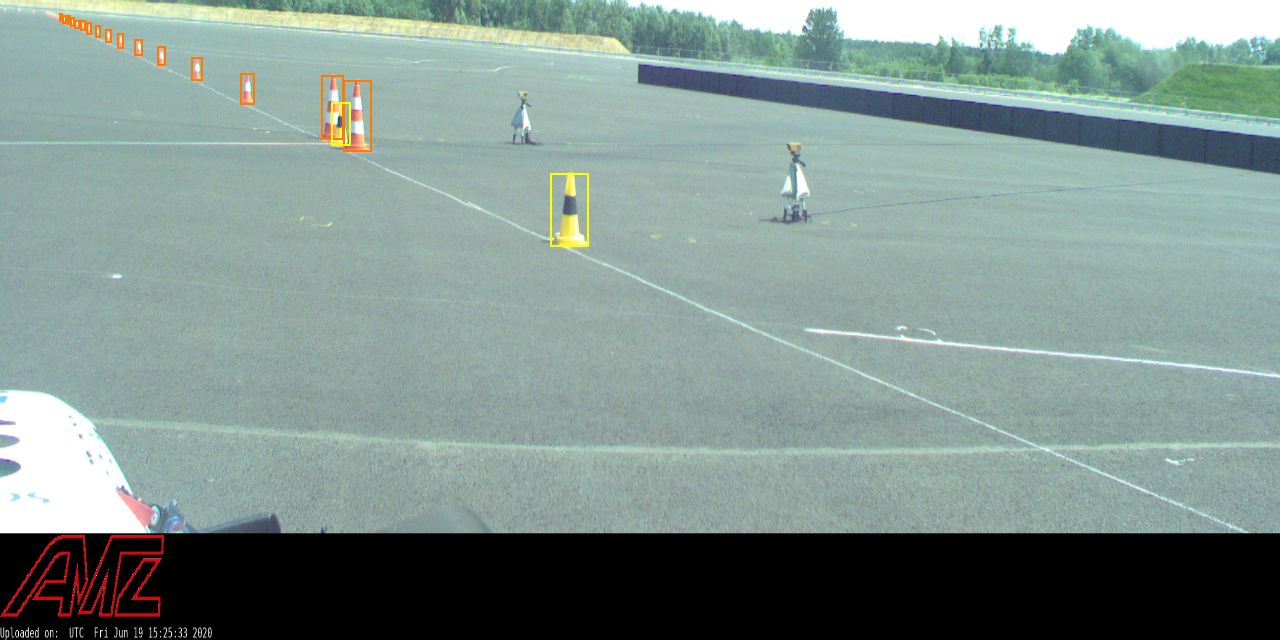

In [8]:
data = FS_COCO_Dataset(image_path_list, labels_path_list, test_transforms) 
image, target = data[8]
print(image.shape)
show_image_with_objects(image, target['boxes'], target['labels'])

In [12]:
class yolov8_n(torch.nn.Module):
    def __init__(self, num_classes: int=4) -> None:
        super().__init__()
        
        self.num_classes = num_classes + 1
        self.model = nn.yolo_v8_n(num_classes)

        for child in list(self.model.children()):
              for param in child.parameters():
                    param.requires_grad = True

    def predict(self, X: torch.Tensor) -> torch.Tensor:
        return self.model(X)

    # To calculate the loss function
    def forward(self, images: List[torch.Tensor], annotation: List[Dict[str, torch.Tensor]]) -> Dict[str, int]:
        return self.model(images, annotation)
    
yolov8_n()

yolov8_n(
  (model): YOLO(
    (net): DarkNet(
      (p1): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (norm): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (relu): SiLU(inplace=True)
        )
      )
      (p2): Sequential(
        (0): Conv(
          (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (norm): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (relu): SiLU(inplace=True)
        )
        (1): CSP(
          (conv1): Conv(
            (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (relu): SiLU(inplace=True)
          )
          (conv2): Conv(
            (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias

In [13]:
train_data, test_data = train_test_split(list(zip(image_path_list[:1000], labels_path_list[:1000])), test_size=0.3, shuffle=True, random_state=42)
val_data, data_data = train_test_split(test_data, test_size=0.1, shuffle=True, random_state=42)

train_data = FS_COCO_Dataset(list(items[0] for items in train_data),
                             list(items[1] for items in train_data),
                             transform=train_transforms)

test_data = FS_COCO_Dataset(list(items[0] for items in test_data),
                            list(items[1] for items in test_data),
                            transform=test_transforms)

val_data = FS_COCO_Dataset(list(items[0] for items in val_data),
                           list(items[1] for items in val_data),
                           transform=test_transforms)

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                               batch_size=8,
                                               shuffle=True,
                                               num_workers=os.cpu_count(),
                                               collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(dataset=val_data,
                                             batch_size=8,
                                             shuffle=False,
                                             num_workers=os.cpu_count(),
                                             collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data,
                                              batch_size=4,
                                              shuffle=False,
                                              num_workers=os.cpu_count(),
                                              collate_fn=collate_fn)

In [15]:
def train_step(device: torch.device,
               model: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               dataloader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module = None,
               scheduler: torch.optim.lr_scheduler = None):

    model.to(device)
    model.train()

    train_loss = 0
    torch.cuda.empty_cache()

    time_epoch_start = time()

    for batch, (images, annotations) in enumerate(dataloader):

        images = [torch.Tensor(image).to(device) for image in images]
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

        if criterion == None:
            loss_dict = model(images, annotations)
            loss = sum(loss for loss in loss_dict.values())
        else:
            pass
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        print(f"LOSSES: {loss}")
        # print(model(images[0]))

    train_loss = train_loss / len(dataloader)
    time_epoch_end = time() - time_epoch_start

    return train_loss, time_epoch_end



@torch.no_grad()
def validation_step(device: torch.device,
                    model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    criterion: torch.nn.Module = None):
    model.to(device)
    model.eval()

    val_loss = 0
    min_val_loss = 1e6
    torch.cuda.empty_cache()

    time_epoch_start = time()
    with torch.inference_mode():
        for batch, (images, annotations) in enumerate(dataloader):

            images = [torch.Tensor(image).to(device) for image in images]
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

            if criterion == None:
                model.train()
                loss_dict = model(images, annotations)
                # print(loss_dict)
                loss = sum(loss for loss in loss_dict.values())
                model.eval()
            else:
                pass
            val_loss += loss.item()

      # print(f"TESTING MODEL {model.predict(images)}"
      # print(f"LOSSES: {loss}")

    val_loss /= len(dataloader)
    time_epoch_end = time() - time_epoch_start

  # val_loss = validate(epoch)
    if val_loss < min_val_loss:
        print('NEW BEST MODEL!')
        torch.save(model.state_dict(), 'best_model.pth')
        min_val_loss = val_loss
    torch.save(model.state_dict(), 'latest_model.pth')

    return val_loss, time_epoch_end



def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: torch.device):
    
    log_output = {
                  'train_loss': [],
                  'val_loss': [],
                  'val_mAP': []
                 }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_train_epoch = train_step(model=model,
                                                   dataloader=train_dataloader,
                                                   optimizer=optimizer,
                                                   device=device)

        print(f"EPOCH: {epoch+1} | TRAIN LOSS: {train_loss} | TRAIN TIME: {train_train_epoch}")

        val_loss, val_time_epoch = validation_step(model=model,
                                                   dataloader=test_dataloader,
                                                   device=device)
        log_output['train_loss'].append(train_loss)
        log_output['val_loss'].append(val_loss)
#         log_output['val_mAP'].append(train_loss)

        print(f"EPOCH: {epoch+1} | VAL LOSS: {val_loss} | VAL TIME: {val_time_epoch}\n")

In [38]:
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path_to_weights_model = pathlib.Path("best_model.pth")

model = yolov8_n()

# model.load_state_dict(torch.load(path_to_weights_model, map_location=torch.device('cpu')))

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-3)

# train(model, train_dataloader, val_dataloader, optimizer, num_epochs, device)

In [39]:
image, target = random.choice(test_data)
print(image.shape)

# images = [torch.Tensor(image.transpose(2, 0, 1)).to(device) for image in images]
# annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

with torch.no_grad():
    model.eval()
    model.to(device)
    outputs = model.predict(torch.Tensor(image).unsqueeze(dim=0).to(device))
print(outputs.shape)

# bboxes, labels, scores = objects_threshold_scores(outputs[0]['boxes'].to('cpu'), outputs[0]['labels'], outputs[0]['scores'], 0.2)
# print(labels, bboxes, scores)

# fig, axes = plt.subplots(1, 2, figsize=(15, 7))
# axes[0].imshow(show_image_with_objects(image, bboxes, labels))

# axes[1].imshow(show_image_with_objects(image, target['boxes'], target['labels']))

# axes[0].set_title("Prediction")
# axes[1].set_title("Ground Truth")

# axes[0].axis('off')
# axes[1].axis('off')
# plt.show()

(3, 640, 1280)
torch.Size([1, 8, 16800])


In [10]:
import argparse
import copy
import csv
import os
import warnings

import numpy
import torch
import tqdm
import yaml
from torch.utils import data

from models.yolov8.nets import nn
from models.yolov8.utils import util
from models.yolov8.utils.dataset import Dataset

warnings.filterwarnings("ignore")


def learning_rate(args, params):
    def fn(x):
        return (1 - x / args.epochs) * (1.0 - params['lrf']) + params['lrf']

    return fn


def train(args, params):
    # Model
    # model = nn.yolo_v8_n(len(params['names'].values())).cuda()

    # Optimizer
    accumulate = max(round(64 / (args.batch_size * args.world_size)), 1)
    params['weight_decay'] *= args.batch_size * args.world_size * accumulate / 64

    p = [], [], []
    for v in model.modules():
        if hasattr(v, 'bias') and isinstance(v.bias, torch.nn.Parameter):
            p[2].append(v.bias)
        if isinstance(v, torch.nn.BatchNorm2d):
            p[1].append(v.weight)
        elif hasattr(v, 'weight') and isinstance(v.weight, torch.nn.Parameter):
            p[0].append(v.weight)

    optimizer = torch.optim.SGD(p[2], params['lr0'], params['momentum'], nesterov=True)

    optimizer.add_param_group({'params': p[0], 'weight_decay': params['weight_decay']})
    optimizer.add_param_group({'params': p[1]})
    del p

    # Scheduler
    lr = learning_rate(args, params)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr, last_epoch=-1)

    # EMA
    ema = util.EMA(model) if args.local_rank == 0 else None

    filenames = []
    with open('../Dataset/COCO/train2017.txt') as reader:
        for filename in reader.readlines():
            filename = filename.rstrip().split('/')[-1]
            filenames.append('../Dataset/COCO/images/train2017/' + filename)

    dataset = Dataset(filenames, args.input_size, params, True)

    if args.world_size <= 1:
        sampler = None
    else:
        sampler = data.distributed.DistributedSampler(dataset)

    loader = data.DataLoader(dataset, args.batch_size, sampler is None, sampler,
                             num_workers=8, pin_memory=True, collate_fn=Dataset.collate_fn)

    if args.world_size > 1:
        # DDP mode
        model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model)
        model = torch.nn.parallel.DistributedDataParallel(module=model,
                                                          device_ids=[args.local_rank],
                                                          output_device=args.local_rank)

    # Start training
    best = 0
    num_batch = len(loader)
    amp_scale = torch.cuda.amp.GradScaler()
    criterion = util.ComputeLoss(model, params)
    num_warmup = max(round(params['warmup_epochs'] * num_batch), 1000)
    with open('weights/step.csv', 'w') as f:
        if args.local_rank == 0:
            writer = csv.DictWriter(f, fieldnames=['epoch', 'mAP@50', 'mAP'])
            writer.writeheader()
        for epoch in range(args.epochs):
            model.train()

            if args.epochs - epoch == 10:
                loader.dataset.mosaic = False

            m_loss = util.AverageMeter()
            if args.world_size > 1:
                sampler.set_epoch(epoch)
            p_bar = enumerate(loader)
            if args.local_rank == 0:
                print(('\n' + '%10s' * 3) % ('epoch', 'memory', 'loss'))
            if args.local_rank == 0:
                p_bar = tqdm.tqdm(p_bar, total=num_batch)  # progress bar

            optimizer.zero_grad()

            for i, (samples, targets, _) in p_bar:
                x = i + num_batch * epoch  # number of iterations
                samples = samples.cuda().float() / 255
                targets = targets.cuda()

                # Warmup
                if x <= num_warmup:
                    xp = [0, num_warmup]
                    fp = [1, 64 / (args.batch_size * args.world_size)]
                    accumulate = max(1, numpy.interp(x, xp, fp).round())
                    for j, y in enumerate(optimizer.param_groups):
                        if j == 0:
                            fp = [params['warmup_bias_lr'], y['initial_lr'] * lr(epoch)]
                        else:
                            fp = [0.0, y['initial_lr'] * lr(epoch)]
                        y['lr'] = numpy.interp(x, xp, fp)
                        if 'momentum' in y:
                            fp = [params['warmup_momentum'], params['momentum']]
                            y['momentum'] = numpy.interp(x, xp, fp)

                # Forward
                with torch.cuda.amp.autocast():
                    outputs = model(samples)  # forward
                loss = criterion(outputs, targets)

                m_loss.update(loss.item(), samples.size(0))

                loss *= args.batch_size  # loss scaled by batch_size
                loss *= args.world_size  # gradient averaged between devices in DDP mode

                # Backward
                amp_scale.scale(loss).backward()

                # Optimize
                if x % accumulate == 0:
                    amp_scale.unscale_(optimizer)  # unscale gradients
                    util.clip_gradients(model)  # clip gradients
                    amp_scale.step(optimizer)  # optimizer.step
                    amp_scale.update()
                    optimizer.zero_grad()
                    if ema:
                        ema.update(model)

                # Log
                if args.local_rank == 0:
                    memory = f'{torch.cuda.memory_reserved() / 1E9:.3g}G'  # (GB)
                    s = ('%10s' * 2 + '%10.4g') % (f'{epoch + 1}/{args.epochs}', memory, m_loss.avg)
                    p_bar.set_description(s)

                del loss
                del outputs

            # Scheduler
            scheduler.step()

            if args.local_rank == 0:
                # mAP
                last = test(args, params, ema.ema)
                writer.writerow({'mAP': str(f'{last[1]:.3f}'),
                                 'epoch': str(epoch + 1).zfill(3),
                                 'mAP@50': str(f'{last[0]:.3f}')})
                f.flush()

                # Update best mAP
                if last[1] > best:
                    best = last[1]

                # Save model
                ckpt = {'model': copy.deepcopy(ema.ema).half()}

                # Save last, best and delete
                torch.save(ckpt, './weights/last.pt')
                if best == last[1]:
                    torch.save(ckpt, './weights/best.pt')
                del ckpt

    if args.local_rank == 0:
        util.strip_optimizer('./weights/best.pt')  # strip optimizers
        util.strip_optimizer('./weights/last.pt')  # strip optimizers

    torch.cuda.empty_cache()


@torch.no_grad()
def test(args, params, model=None):
    filenames = []
    with open('../Dataset/COCO/val2017.txt') as reader:
        for filename in reader.readlines():
            filename = filename.rstrip().split('/')[-1]
            filenames.append('../Dataset/COCO/images/val2017/' + filename)

    dataset = Dataset(filenames, args.input_size, params, False)
    loader = data.DataLoader(dataset, 8, False, num_workers=8,
                             pin_memory=True, collate_fn=Dataset.collate_fn)

    if model is None:
        model = torch.load('./weights/best.pt', map_location='cuda')['model'].float()

    model.half()
    model.eval()

    # Configure
    iou_v = torch.linspace(0.5, 0.95, 10).cuda()  # iou vector for mAP@0.5:0.95
    n_iou = iou_v.numel()

    m_pre = 0.
    m_rec = 0.
    map50 = 0.
    mean_ap = 0.
    metrics = []
    p_bar = tqdm.tqdm(loader, desc=('%10s' * 3) % ('precision', 'recall', 'mAP'))
    for samples, targets, shapes in p_bar:
        samples = samples.cuda()
        targets = targets.cuda()
        samples = samples.half()  # uint8 to fp16/32
        samples = samples / 255  # 0 - 255 to 0.0 - 1.0
        _, _, height, width = samples.shape  # batch size, channels, height, width

        # Inference
        outputs = model(samples)

        # NMS
        targets[:, 2:] *= torch.tensor((width, height, width, height)).cuda()  # to pixels
        outputs = util.non_max_suppression(outputs, 0.001, 0.65)

        # Metrics
        for i, output in enumerate(outputs):
            labels = targets[targets[:, 0] == i, 1:]
            correct = torch.zeros(output.shape[0], n_iou, dtype=torch.bool).cuda()

            if output.shape[0] == 0:
                if labels.shape[0]:
                    metrics.append((correct, *torch.zeros((3, 0)).cuda()))
                continue

            detections = output.clone()
            util.scale(detections[:, :4], samples[i].shape[1:], shapes[i][0], shapes[i][1])

            # Evaluate
            if labels.shape[0]:
                tbox = labels[:, 1:5].clone()  # target boxes
                tbox[:, 0] = labels[:, 1] - labels[:, 3] / 2  # top left x
                tbox[:, 1] = labels[:, 2] - labels[:, 4] / 2  # top left y
                tbox[:, 2] = labels[:, 1] + labels[:, 3] / 2  # bottom right x
                tbox[:, 3] = labels[:, 2] + labels[:, 4] / 2  # bottom right y
                util.scale(tbox, samples[i].shape[1:], shapes[i][0], shapes[i][1])

                correct = numpy.zeros((detections.shape[0], iou_v.shape[0]))
                correct = correct.astype(bool)

                t_tensor = torch.cat((labels[:, 0:1], tbox), 1)
                iou = util.box_iou(t_tensor[:, 1:], detections[:, :4])
                correct_class = t_tensor[:, 0:1] == detections[:, 5]
                for j in range(len(iou_v)):
                    x = torch.where((iou >= iou_v[j]) & correct_class)
                    if x[0].shape[0]:
                        matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1)
                        matches = matches.cpu().numpy()
                        if x[0].shape[0] > 1:
                            matches = matches[matches[:, 2].argsort()[::-1]]
                            matches = matches[numpy.unique(matches[:, 1], return_index=True)[1]]
                            matches = matches[numpy.unique(matches[:, 0], return_index=True)[1]]
                        correct[matches[:, 1].astype(int), j] = True
                correct = torch.tensor(correct, dtype=torch.bool, device=iou_v.device)
            metrics.append((correct, output[:, 4], output[:, 5], labels[:, 0]))

    # Compute metrics
    metrics = [torch.cat(x, 0).cpu().numpy() for x in zip(*metrics)]  # to numpy
    if len(metrics) and metrics[0].any():
        tp, fp, m_pre, m_rec, map50, mean_ap = util.compute_ap(*metrics)

    # Print results
    print('%10.3g' * 3 % (m_pre, m_rec, mean_ap))

    # Return results
    model.float()  # for training
    return map50, mean_ap

model = nn.yolo_v8_n().cuda()

for child in list(model.children()):
    for param in child.parameters():
        param.requires_grad = True